<a href="https://colab.research.google.com/github/MiguelAngel-ht/escuela-de-computacion-cuantica-2023/blob/main/hackathon/Solution_Jingle_Bell_States/IBM_Quantum_Image_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚪

---
---
# **⚛️— — — — — Quantum Image Filtering — — — — —⚛️**
---
---

⚪



# Quantum Circuits for Random Number Generation and Image Modification

In this notebook, we implement two types of quantum circuits to generate random numbers and use them to modify images in different ways.

We have designed two processes/methodologies to build our quantum circuits depending on the problem at hand. The problems in question are:

- **Black/White Images**
- **Grayscale Images**

## Black/White Images

In black/white images, pixels can only have two values: 0 (black) or 255 (white). For such images, we decided that each pixel in the image would correspond to a qubit in a quantum circuit. Upon measurement, this qubit will collapse to 0 or 1 with a probability that the user can control. Depending on the outcome, the effect on the pixel is as follows:

- Collapses to 0: The corresponding pixel remains unchanged.
- Collapses to 1: The corresponding pixel switches from white to black or vice versa.

The user can control the following parameters:

- **Input Image:** The user can upload and select the image on which to apply the filter. We recommend using 512x512 images for best results.
- **Threshold:** The image chosen by the user might not always be in Black/White style. In such cases, the user can control the threshold value for converting the image.
- **Probability/Noise:** This is a value between 0 - 1 that indicates the probability of each pixel to change (in other words, the qubits collapsing to 1). This is done by adding an RY gate, mapping the user-entered value to a phase in the range of -π/2 to π/2.
- **Modify:** This parameter indicates where in the image the pixel changes are made. The user can control whether the modification occurs on white pixels, black pixels, or all pixels.


## Grayscale Images

In grayscale images, pixels can have any value in the range from 0 (black) to 255 (white). For this case, we implemented a circuit that generates random numbers in a specific range [a, b), inspired by [[1]](https://doi.org/10.1140/epjqt/s40507-023-00174-1)

Following a methodology similar to the "filter" technique in the field of digital image processing, we generate an ***nxn*** kernel that moves across the image and modifies it as follows:

During each iteration, the kernel's center is positioned on an image pixel. The largest and smallest intensity values within the kernel's range are calculated. Based on this range of values, a circuit is automatically designed to generate random numbers within it. The result from measuring this circuit is assigned as the new value to the pixel at the kernel's center. This process is repeated until all the pixels in the image have been processed.

This methodology has its limitations, as it generates and measures a quantum circuit for each image pixel. For a high-quality image (512x512 pixels), this means 262,144 circuits will be generated, implying substantial computational time. To address this, we have taken the following considerations:

- **Image Resizing:** The user-uploaded image will be internally resized to a resolution of 128x128. The filter is applied to this resized image, and the output is then scaled back to the original image dimensions.
- **Intensity Range Mapping:** To reduce the number of qubits needed to build the circuit, the original intensity range of 0 to 255 is mapped to a grayscale range of 0 to 31. Since humans do not perceive many shades of gray, this modification rarely alters our perception of the result.

The user can control the following parameters:

- **Input Image:** The user can upload and select the image to apply the filter.
- **Kernel Size:** The user can choose from different kernel size configurations (e.g., 3x3, 5x5, etc.).
- **Internal Resize Value:** We strongly recommend keeping this parameter set to the default of 128x128. Increasing it to 256x256 will aproximately quadruple the execution time (as the number of pixels also increases).



## **Note for Grayscale Images:**

 Depending on the complexity of the image and the chosen internal resize setting, the code execution may take approximately:
- **Resize 128x128:** About 3 to 6 minutes
- **Resize 256x256:** About 12 to 24 minutes

## ⬇️ Install Qiskit and Import Libraries

In [ ]:
#@title ⬇️ *Install Qiskit*
from google.colab import output     # clear output when is not necessary
!pip install qiskit
#!pip install qiskit-ibmq-provider    # Date: 2023 - Installing apart of 'qiskit'
#!pip install qiskit[visualization]   # Qiskit to parameter "mpl" works in colab
!pip install pylatexenc
!pip install qiskit-aer
output.clear()

In [ ]:
#@title ⬇️ *Import Libraries*
# Basic Libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
# Qiskit modules
from qiskit import QuantumCircuit, transpile,  Aer, execute
from qiskit.primitives import Sampler
# Libraries for interactive notebook (Colab)
from google.colab import files, output
from IPython.display import Image, display
import ipywidgets as widgets
import os

## ⬇️ Defining functions and Filter Classes

In [ ]:
#@title ⬇️ *Auxiliary Functions for Gray Scale Filter*

# Auxiliar Functions for Gray Scale Filter
def create_AND_gate():
    # Creating a circuit where the AND gate will be designed
    qc = QuantumCircuit(3)
    # Adding CNOTs
    qc.cx(0,2)
    qc.cx(1,2)
    qc.cx(2,1)
    qc.cx(2,0)
    # Adding T and T dagger gates
    qc.tdg(0)
    qc.tdg(1)
    qc.t(2)
    # Inverse operation of the last 2 CNOTs
    qc.cx(2,0)
    qc.cx(2,1)
    # Hadamard and S gate on the qubit with the result
    qc.h(2)
    qc.s(2)
    # Saving the circuit as a gate with the name "AND"
    temp_log_and = qc.to_gate()
    temp_log_and.name = "AND"
    return temp_log_and

def create_comparator(b, nqubits):
    # Creating a circuit where the comparator will be designed
    qc = QuantumCircuit(2*nqubits + 1)
    # Create Temporary Logical AND Gate
    temp_log_and = create_AND_gate()

    # Positions of 'a' qubits
    qbits_ai_position = [2*i + 1 if i != 0 else i for i in range(nqubits)]

    # Add a CNOT to each 'a' qubit
    for i in qbits_ai_position:
        qc.x(i)

    # Implementing the Comparator

    # If the first digit of the binary number b is '1', place a Pauli X gate (on qubit 1), otherwise place an identity
    if b[0] == '1':
        qc.x(1)
    else:
        qc.id(1)

    # Compare with an AND gate the qubits 0 (first 'a' qubit) and 1 (auxiliary qubit |0>) and send the result to qubit 2 (first auxiliary 'A' qubit)
    qc.append(temp_log_and, [0,1,2])

    # Perform the inverse operation on qubit 1
    if b[0] == '1':
        qc.x(1)
    else:
        qc.id(1)

    # For aesthetics, add an identity on qubit 2
    qc.id(2)

    # Loop from 1 to N-1 to compare each digit of the binary number 'a' with 'b'
    for j in range(1, nqubits):

        # Compare the next digit of b
        if b[j] == '1':
            qc.x(1)
        else:
            qc.id(1)

        # Perform a CNOT that takes the result stored in the corresponding auxiliary 'A' qubit
        # and passes the outcome of the gate to the next 'a' qubit
        qc.cx(2*j, 2*j+1)

        # Take the result of 'A' to input to the AND in qubit 1
        qc.cx(2*j, 1)

        # AND gate that compares the temporary value of qubit 1 with each of the 'a' qubits and stores the result in the 'A' auxiliaries
        qc.append(temp_log_and, [1, 2*j+1, 2*j+2])

        # Inverse CNOT operation to the previous one
        qc.cx(2*j, 1)

        # Perform the inverse operation to the compared b digit
        if b[j] == '1':
            qc.x(1)
        else:
            qc.id(1)

        # Pass the result to the next 'a' qubit
        qc.cx(2*j, 2*j+2)

    # Saving the circuit as a gate with the name "COMPARATOR"
    COMPARATOR = qc.to_gate()
    COMPARATOR.name = "Comparator"
    return COMPARATOR

def create_circuit(min_value,max_value):
    # Computing the difference l between max_value - min_value (length of range)
    l = max_value - min_value
    # l can't be 0 because we need a range to generate the random numbers
    if l==0:
        l = 1
    # Obtain the number of qubits needed to build the circuit
    nqubits = len(bin(l)[2:])
    # The minimun value of nqubits must be 3
    if nqubits < 3:
        nqubits = 3
    # Convert the range to binary
    b_init = format(l+1, '0{}b'.format(str(nqubits)))
    a_init = format(0, '0{}b'.format(str(nqubits)))
    a = a_init[::-1]
    b = b_init[::-1]

    # Customed Comparator Gate
    COMPARATOR = create_comparator(b, nqubits)

    # Defining intial states of A qubits (auxiliar qubits)
    state = [1/np.sqrt(2), (1 + 1j)/2]

    # Creating the quantum circuit of 2n + 2 qubits and n classical qubits (for measuring the final digits)
    qc = QuantumCircuit(2*nqubits + 2, nqubits)

    # Positions of qubits 'a' and 'A'
    qbits_ai_position = [2*i + 1 if i != 0 else i for i in range(nqubits)]
    qbits_Ai_position = [2*i + 2 for i in range(nqubits)]

    # Inicializar el último qbit como 1
    qc.x(2*nqubits + 1)
    qc.barrier()

    # Initialize the last qubit as 1
    for i, j in zip(qbits_ai_position, qbits_Ai_position):
        qc.h(i)                   # Put 'a' qubits into superposition
        qc.initialize(state, j)   # Initialize with the state (0.707, 0.5+0.5j) on 'A' qubits
    qc.barrier()

    # Number of times the oracle and the amplifier should be used
    N = int((np.pi/4) * np.sqrt(2**nqubits/l))

    # Placing the Oracle and the Amplifier (N times)
    for t in range(N):

        # Adding the ORACLE to the circuit
        qc.append(COMPARATOR, range(0, 2*nqubits+1))

        # Get the result (0 if a<b, 1 otherwise)
        qc.cx(2*nqubits, 2*nqubits+1)

        # Performing inverse operations
        qc.append(COMPARATOR.inverse(), range(0,2*nqubits+1))

        # Separator
        qc.barrier()

        # Adding the AMPLIFIER to the circuit
        for i in qbits_ai_position:
            qc.h(i)     # Hadamard gate
            qc.x(i)     # Pauli X gate

        # Adding Hadamard gates on the last 'a' qubit around a Toffoli gate acting on 'a' qubits
        qc.h(qbits_ai_position[-1])
        qc.mcx(qbits_ai_position[:-1], qbits_ai_position[-1])
        qc.h(qbits_ai_position[-1])

        # Separator
        qc.barrier()

        # Completing the amplifier with inverse operations
        for i in qbits_ai_position:

            qc.x(i)     # Compuerta X de Pauli
            qc.h(i)     # Compuerta Hadamard

        # Hadamard gate on the last qubit to perform the inverse operation
        qc.h(2*nqubits + 1)
        qc.barrier()

    # Measure each resulting qubit (bits of the generated random number)
    for j, k in enumerate([2*i + 1 if i != 0 else i for i in range(nqubits)]):
        qc.measure(k,j)

    # Transpiling the circuit
    qc = transpile(qc,optimization_level=3)
    return qc

def computing_kernel(original_image, kernel_size = 9):
    # Reduce to 32 shades of gray
    image = original_image // 8

    # Auxiliary variable based on the kernel size
    k = kernel_size // 2

    # Create mirror padding (border)
    padded_image = cv2.copyMakeBorder(image, k,k,k,k, cv2.BORDER_REFLECT)

    # Prepare the array to store the results (min and max per kernel)
    min_max_array = np.zeros((image.shape[0], image.shape[1], 2), dtype=image.dtype)

    # Traverse the image with a kernel of 5x5
    for i in range(k, padded_image.shape[0] - k):
        for j in range(k, padded_image.shape[1] - k):

            # Extract the 5x5 kernel
            kernel = padded_image[i-k:i+k+1, j-k:j+k+1]

            # Find the minimum and maximum in the kernel
            min_val, max_val = np.min(kernel), np.max(kernel)

            # Save the values in the corresponding array
            min_max_array[i-k, j-k] = (min_val, max_val)

    return min_max_array

def run_circuits(original_image, circuits, kernels):
    # Initialize the Sampler
    sampler = Sampler()

    # Prepare a new image array with the same size as the original image and the same data type
    new_image = np.zeros((original_image.shape[0], original_image.shape[1]), dtype=original_image.dtype)

    # Iterate over each row of the new image
    for i in range(new_image.shape[0]):
        # Run the quantum circuit for the current row with the specified number of shots
        job = sampler.run(circuits=circuits.tolist()[i], shots = 100)
        # Get the quasi-probability distributions of the circuit results
        results = job.result().quasi_dists
        # Update the new image row with the most probable result from each circuit's output
        new_image[i,:] = [max(result, key=result.get) for result in results]

    # Add the kernel's first layer (min value) to the new image for final processing
    new_image = new_image + kernels[:,:,0]
    return new_image

In [ ]:
#@title ⬇️ *Gray Scale Filter class (Quantum_Filter)*
class Quantum_Filter:
    def __init__(self, image_path):
        # Load the image from the specified path as a grayscale image and store it in self.original_image
        self.original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Store the size of the original image
        self.original_size = self.original_image.shape

    def load_image(self, image_path):
        # Load the image from the specified path and store it in self.original_image
        self.original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Update the size of the original image
        self.original_size = self.original_image.shape

    def apply_quantum_filter(self, kernel_size = 3, resize =  128):
        # Apply a quantum filter to the image and update self.image
        # Resize the image for quantum processing
        resized_image = cv2.resize(self.original_image,(resize, resize), cv2.INTER_LANCZOS4)
        # Compute the kernel of the resized image for filtering
        kernels = computing_kernel(resized_image, kernel_size)
        # Initialize an array to keep track of repeated values
        repeated = np.ones((resized_image.shape[0], resized_image.shape[1])) * -1
        # Build quantum circuits for each pixel based on the kernel calculations
        circuits = np.empty((resized_image.shape[0], resized_image.shape[1]), dtype=object)
        for i in range(len(kernels)):
            for j in range(len(kernels[0])):
                min = kernels[i,j,0]
                max = kernels[i,j,1]
                l = max-min
                pos_l = np.where(repeated == l)
                pos_l = list(zip(pos_l[0], pos_l[1]))
                if len(pos_l) == 0:
                    circuits[i,j] = create_circuit(min,max)
                    repeated[i,j] = l
                else:
                    circuits[i,j] = circuits[pos_l[0]]
        # Run the quantum circuits to get the new filtered image
        new_image = run_circuits(resized_image, circuits, kernels)
        # Dealing with errors, due to the probabilistic nature of quantum circuits, some times the random value is out of range
        new_image = np.where(new_image > kernels[:, :, 1], kernels[:, :, 1], new_image)
        # Scale up the pixel values from the 32 gray shades used to 255
        new_image = new_image*8
        # Resize the new image back to the original dimensions
        self.modified_image = cv2.resize(new_image, self.original_size[::-1], cv2.INTER_LANCZOS4)
        return self.original_image, self.modified_image

    def show_image(self, figsize = (8,4)):
        # Show both the original and processed images
        # Configure the plot to display both images
        fig, axs = plt.subplots(1, 2, figsize = figsize)

        # Display the original image
        axs[0].imshow(self.original_image, cmap='gray')
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        # Display the modified image
        axs[1].imshow(self.modified_image, cmap='gray')
        axs[1].set_title('Modified Image')
        axs[1].axis('off')

        # Adjust the layout of the images
        plt.tight_layout()

        # Show the plot with the images
        plt.show()

In [ ]:
#@title ⬇️ *Auxiliary Functions for Black-White Filter*

def expand_image_bw(img, m):
    # Get the shape of the image
    n = img.shape
    # Compute the padding required to expand the image to a multiple of 'm' pixels
    left_padding = m - (n[0] % m) # compute the remainder for the rows
    top_padding = m - (n[1] % m)  # compute the remainder for the columns

    # Expand the image by adding reflected padding to the top and left side
    expanded_image = cv2.copyMakeBorder(img, top_padding, 0, left_padding, 0, cv2.BORDER_REFLECT)
    return expanded_image, left_padding, top_padding

def preprocess_image_bw(img, threshold = 128):
    # Apply thresholding to convert the image to black and white
    _ , thresholded_image = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    # Expand the image to ensure its dimensions are a multiple of 3 pixels
    expanded_image, left_padding, top_padding = expand_image_bw(thresholded_image, 3)
    return expanded_image, left_padding, top_padding

def create_circuit_bw(prob):
    # Map a probability value from 0 - 1 to the range -pi/2 to pi/2 to set the phase
    phase = -np.pi / 2 + prob * np.pi
    # Build a quantum circuit for 9 qubits, with each qubit initialized to a Hadamard gate state
    # followed by a rotation 'RY' gate based on the calculated phase
    qc = QuantumCircuit(9, 9)
    qc.h(range(9))
    qc.ry(phase, range(9))
    qc.measure(range(9),range(9))
    return qc

def simulate_circuit_bw(img, qc):
    # Calculate the number of rows and columns in the expanded image
    n_rows = int(img.shape[0]/3)  # Number of 3-pixel high rows
    n_col = int(img.shape[1]/3)   # Number of 3-pixel wide columns
    # Simulate the quantum circuit for each row block of the expanded image
    backend = Aer.get_backend('qasm_simulator')
    # Initialize an empty array for the new image
    random_matrix = np.empty((0, img.shape[1]))
    for i in range(n_rows):
        row = np.empty((3, 0))  # Initialize an empty 3-pixel row
        job = execute(qc, backend, shots=n_col, memory=True)
        results = job.result().get_memory()
        for result in results:
            # Convert binary string results into a numpy array of integers
            bin_array = np.array([int(bit) for bit in result])
            # Reshape the 9 bits into a 3x3 block
            bin_matrix = bin_array.reshape((3, 3))
            # Concatenate to the row
            row = np.concatenate((row, bin_matrix), axis=1)
        # Add the 3-pixel row to the full image
        random_matrix = np.concatenate((random_matrix, row), axis=0)
    random_matrix = random_matrix.astype(np.uint8)
    return random_matrix

In [ ]:
#@title ⬇️ *Black-White Filter class (Quantum_Filter_BW)*

class Quantum_Filter_BW:
    def __init__(self, image_path, threshold = 128):
        # Load the image from the specified path as a grayscale image and store in self.original_image
        self.original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Store the size of the original image
        self.original_size = self.original_image.shape
        # Store the threshold value for image preprocessing
        self.threshold = 128

    def load_image(self, image_path, threshold = 128):
        # Load the image from the specified path as a grayscale image and store in self.original_image
        self.original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Store the size of the original image
        self.original_size = self.original_image.shape
        # Store the threshold value for image preprocessing
        self.threshold = 128

    def apply_quantum_filter(self, prob = 0.5, modify = ''):
        # Apply a quantum-inspired filter to the image
        # Preprocess the image to black and white using the specified threshold
        preprocessed_image, left_padding, top_padding = preprocess_image_bw(self.original_image, self.threshold)
        # Define the quantum circuit based on the probability value
        qc = create_circuit_bw(prob)
        # Run the quantum circuit on the preprocessed image to get a random matrix
        random_matrix = simulate_circuit_bw(preprocessed_image, qc)
        # Use the random matrix to modify the preprocessed image based on quantum results
        new_image = np.where(random_matrix == 1, 255 - preprocessed_image, preprocessed_image)
        # If 'modify' is set to 'black', ensure that originally white pixels stay white
        if modify == 'black':
            new_image[np.where(preprocessed_image == 255)] = 255
        # If 'modify' is set to 'white', ensure that originally black pixels stay black
        if modify == 'white':
            new_image[np.where(preprocessed_image == 0)] = 0

        # Trim the padded area from the modified image to restore original dimensions
        self.modified_image = new_image[left_padding:, top_padding:]

        return self.original_image, self.modified_image

    def show_image(self, figsize = (8,4)):
        # Display the original and processed images side by side
        # Configure the figure to display two subplots
        fig, axs = plt.subplots(1, 2, figsize = figsize)

        # Display the original image in the first subplot
        axs[0].imshow(self.original_image, cmap='gray')
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        # Display the original image in the first subplot
        axs[1].imshow(self.modified_image, cmap='gray')
        axs[1].set_title('Modified Image')
        axs[1].axis('off')

        # Adjust the spacing between the images
        plt.tight_layout()

        plt.show()

## **STEP 1:**  Load Your Image 🏞️

#### You should click on '***Choose File***' to upload an image file (of type .jpg, .jpeg, or .png) that is stored on your device.

Uploaded image "Image_512.jpg" with a size of 31726 bytes 



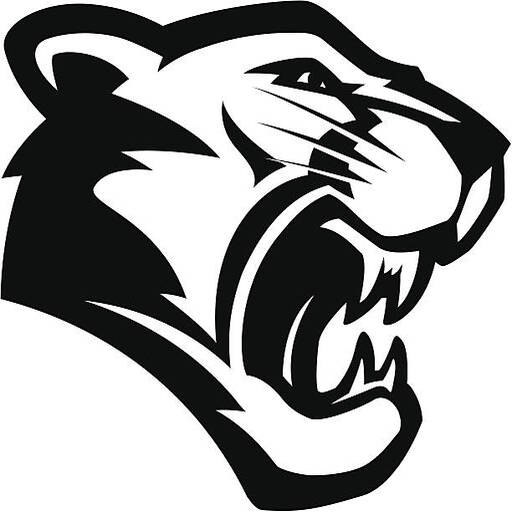

In [ ]:
#@title ⬇️ *Run to load your image*

# Upload files
uploaded = files.upload()

# Process the uploaded files
for filename in uploaded.keys():
    output.clear()  # Clear the output to remove the upload button
    print('Uploaded image "{name}" with a size of {length} bytes \n'.format(
        name=filename, length=len(uploaded[filename])))

    # If it's an image file, display it
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(Image(filename))  # Display the image


## **STEP 2:** Choose a Filter

#### Select the filter you want to apply to your image. 🎨

***Note that filter 2 may take longer to process** 🕒

In [ ]:
#@title ⬇️ Run to select the filter

# Create the radio button widget
filter_type = widgets.RadioButtons(
    options=['Filter 1 - Black/White', 'Filter 2 - Gray Scale'],
    description='',
    disabled=False,
    style={'options_width': 'initial'}
)

# Function to handle the confirmation button click
def on_button_clicked(b):
    global selection
    selection = filter_type.value
    print("You have selected:", selection, "🎨")

# Create and display the confirmation button
print('Choose one: \n')
button = widgets.Button(description="Confirm Selection")
button.on_click(on_button_clicked)
display(filter_type, button)

Choose one: 



RadioButtons(options=('Filter 1 - Black/White', 'Filter 2 - Gray Scale'), value='Filter 1 - Black/White')

Button(description='Confirm Selection', style=ButtonStyle())

You have selected: Filter 2 - Gray Scale 🎨


## **STEP 3:** Customize Values for Your Filter 🧐

#### Enter the parameters depending the Filter Type (amount of noise, where to apply it, kernel size)

In [ ]:
#@title ⬇️ Run to Customize

# If the selected filter is the first option which is Black/White filter
if filter_type.value[7] == '1':
    # Accordion 1: Slider for noise amount
    noise_slider = widgets.FloatSlider(
        value=0.5,
        min=0,
        max=1,
        step=0.1,
        description='Noise:',
        continuous_update=False,
        disabled=False
    )

    # Accordion 2: Dropdown menu with 2 options
    options_menu = widgets.Dropdown(
        options=['In Black', 'In White', 'Across the image'],
        value='In Black',
        description='Menu:',
        disabled=False
    )

    # Accordion 3: Threshold value
    threshold_value = widgets.IntText(
        value=128,
        description='Threshold:',
        disabled=False
    )
    # Create the accordions and assign the widgets to them
    accordion = widgets.Accordion(children=[noise_slider, options_menu, threshold_value])
    accordion.set_title(0, 'Noise Amount')
    accordion.set_title(1, 'Where to apply the filter')
    accordion.set_title(2, 'Threshold Value')

else:
    # Accordion 1: Selection list for kernel size
    kernel_size_list = widgets.Dropdown(
        options=['3x3', '5x5', '7x7'],
        value='3x3',
        description='Kernel:',
        disabled=False
    )
    # Accordion 2: Resize options
    resize_list = widgets.Dropdown(
        options=['128x128 (Recommend)', '256x256'],
        value='128x128 (Recommend)',
        description='Resize:',
        disabled=False
    )
    # Create the accordions and assign the widgets to them
    accordion = widgets.Accordion(children=[kernel_size_list, resize_list])
    accordion.set_title(0, 'Kernel Size')
    accordion.set_title(1, 'Image Resize')

# Display the accordion
display(accordion)


Accordion(children=(Dropdown(description='Kernel:', options=('3x3', '5x5', '7x7'), value='3x3'), Dropdown(desc…

In [ ]:
#@title ⬇️ Select the image you want to apply the filter to

# Get the list of files in the current directory (can be filtered by type if necessary)
file_list = os.listdir()
# Filter for image files if necessary, for example: .png, .jpg, .jpeg
image_files = [file for file in file_list if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Dropdown menu with options being the uploaded image files
images_menu = widgets.Dropdown(
    options=image_files,  # Use the list of image files as options
    description='Files:',
    disabled=False
)

# Create the accordion and assign the widgets to it
accordion = widgets.Accordion(children=[images_menu])
accordion.set_title(0, 'Select Uploaded Image')

# Display the accordion
display(accordion)

Accordion(children=(Dropdown(description='Files:', options=('Image_512.jpg', 'Apple.jpeg'), value='Image_512.j…

## **STEP 4:** Getting Results 📊

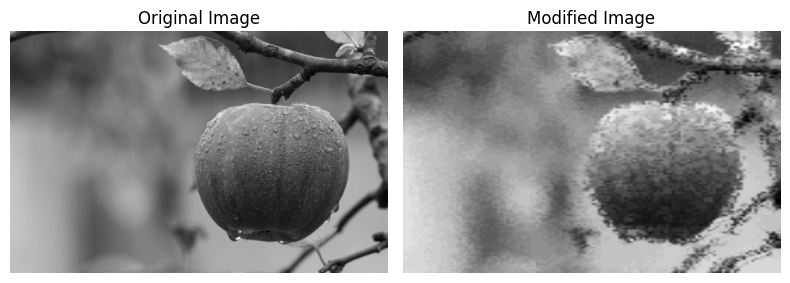

In [ ]:
#@title ⬇️ Run to observe the result

filename = images_menu.value

if selection[7] == '1':
    options_dict = {'In Black': 'black', 'In White': 'white', 'Across the image': ''}
    qf_bw = Quantum_Filter_BW(filename, threshold = threshold_value.value)
    original_image, new_image = qf_bw.apply_quantum_filter(prob = noise_slider.value, modify = options_dict[options_menu.value])
    qf_bw.show_image()

if selection[7] == '2':
    kernel_size = int(kernel_size_list.value[0])
    resize = int(resize_list.value[:3])
    qf_gray = Quantum_Filter(filename)
    original_image, new_image = qf_gray.apply_quantum_filter(kernel_size = kernel_size, resize = resize)
    qf_gray.show_image()



## **Authors**

* Miguel Ángel Hernández Tapia [Github](https://github.com/MiguelAngel-ht)
* David Ángel Alba Bonilla [Github](https://github.com/DavidAlba2627) -- [Blog](https://datasciencelifelonglearn.blogspot.com/)

# **Bibliography**

1. Orts, F., Filatovas, E., Garzón, E. G., & Ortega, G. (2023). A quantum circuit to generate random numbers within a specific interval. EPJ Quantum Technology, 10(1). https://doi.org/10.1140/epjqt/s40507-023-00174-1